In [ ]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 586.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
! pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=893faae72e3b6063ef6b4ea9788554b94917a01331feb7ca3ca8fab289c90b9f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import os
import pandas as pd
import torch
import psutil
import pprint
import evaluate
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer,
    pipeline,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    AdamW,
    get_scheduler
)

from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
rouge_score = evaluate.load("rouge")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google/long-t5-tglobal-base')

config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

До этого у меня был EdinburghNLP/xsum, сейчас CNN.

In [ ]:
dataset = load_dataset('abisee/cnn_dailymail', '1.0.0')

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Посмотрим, сколько там есть вообще текстов

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

Установим ограничения для обработки и пойдём по тому, как разбирали домашку (только немного подредактирую так, как мне удобно это использовать)

In [ ]:
def filter_dataset(dataset, section_name):
    filtered_data = []  #Здесь будем сохранять отфильтрованные данные
    total_rows = len(dataset)
    batch_size = 32 #Следую примеру из разбора

    with tqdm(total=19000, desc=f"Фильтруем {section_name}") as pbar:
        for i in range(0, total_rows, batch_size):  #Разбиваем на батчи
            batch = dataset[i:i + batch_size]  #Берём текущий батч

            #Токенизация батча
            tokenized = tokenizer(batch['article'])

            #Фильтрация токенов
            for text, summary, id, input_ids in zip(batch['article'], batch['highlights'], batch['id'], tokenized['input_ids']):
                token_count = len(input_ids)  #Длина токенов текущего текста
                if 1024 <= token_count <= 2048:  #Проверка на длину
                    filtered_data.append({
                        "article": text,
                        "highlights": summary,
                        "id": id
                    })

                #Ограничение на 10000 текстов
                if len(filtered_data) >= 10000:
                    break

            #Обновляем прогресс-бар
            pbar.update(len(batch))

            #Выход из внешнего цикла, если достигли лимита
            if len(filtered_data) >= 10000:
                break

    return filtered_data[:10000]

In [ ]:
filtered_datasets = {}  #Храним отфильтрованные данные

Tqdm конечно очень странно выводит примерное значение и вообще прогресс...

In [ ]:
for section_name, section_data in dataset.items():

    filtered_data = filter_dataset(section_data, section_name)

    filtered_datasets[section_name] = Dataset.from_dict({
        "article": [row["article"] for row in filtered_data],
        "highlights": [row["highlights"] for row in filtered_data],
        "id": [row["id"] for row in filtered_data]
    })

Фильтруем test:   6%|▌         | 1080/19000 [00:40<11:12, 26.64it/s]


In [ ]:
filtered_datasets

{'train': Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 10000
 }),
 'validation': Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 4485
 }),
 'test': Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 3869
 })}

Строим графики теперь. (Когда я вновь сажусь делать подбор параметров, то следующие несколько ячеек не вижу смысла запускать)

In [ ]:
def get_token_counts(dataset):
    text_token_counts = []  #Храним количество токенов в тексте
    summary_token_counts = []  #Храним количество токенов в саммари

    total_entries = sum(len(section['article']) for section in dataset.values())
    with tqdm(total=total_entries, desc='Обрабатываем весь датасет', unit='entry') as pbar:
        for section_name, section_data in dataset.items():
            for text, summary in zip(section_data['article'], section_data['highlights']):
                text_tokens = tokenizer(text)['input_ids']
                summary_tokens = tokenizer(summary)['input_ids']
                text_token_counts.append(len(text_tokens))
                summary_token_counts.append(len(summary_tokens))
                pbar.update(1)

    return text_token_counts, summary_token_counts

In [ ]:
text_token_counts, summary_token_counts = get_token_counts(filtered_datasets)

Обрабатываем весь датасет: 100%|██████████| 18354/18354 [01:27<00:00, 210.32entry/s]


In [ ]:
mean_text_tokens = np.mean(text_token_counts)
mean_summary_tokens = np.mean(summary_token_counts)
mean_ratio = np.mean(np.array(summary_token_counts) / np.array(text_token_counts))

In [ ]:
print(f"Среднее количество токенов в тексте: {mean_text_tokens}")
print(f"Среднее количество токенов в саммари: {mean_summary_tokens}")
print(f"Среднее соотношение длины саммари к длине текста: {mean_ratio}")

Среднее количество токенов в тексте: 1365.662743816062
Среднее количество токенов в саммари: 79.26724419745015
Среднее соотношение длины саммари к длине текста: 0.059629173255682524


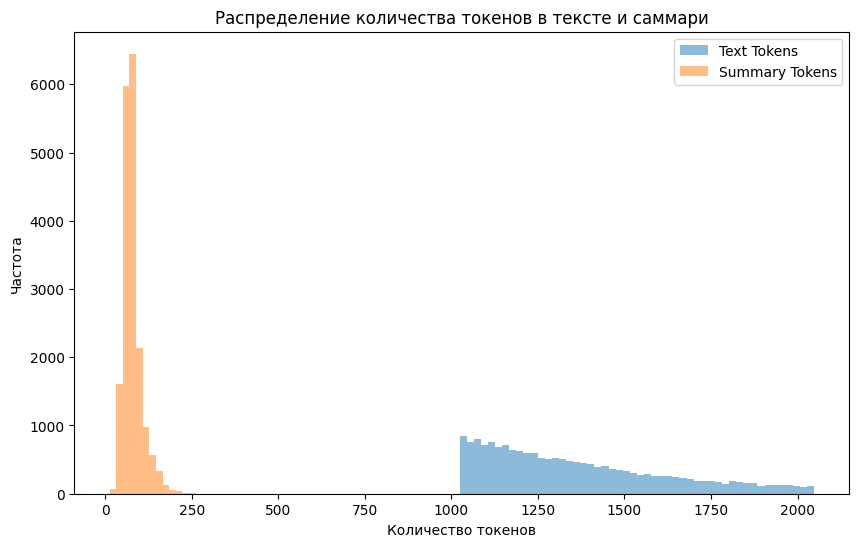

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(text_token_counts, bins=50, alpha=0.5, label='Text Tokens')
plt.hist(summary_token_counts, bins=50, alpha=0.5, label='Summary Tokens')
plt.legend(loc='upper right')
plt.title('Распределение количества токенов в тексте и саммари')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.show()

Средняя длина текста 1365 и саммари в среднем 5% от длины оригинального текста — в целом подходящие данные для условий задачи. График же показвает, что у нас длина в токенах соответствует условию (1024-2048 токенов), причём в основном тексты меньше 1250 токенов (в этой стороне чуть больше пиковых значений). Саммари имеют не очень большой разброс => примерно одинаковы по длинне, что тоже приятно для работы.

Обучение и подбор параметров

Подготовим тексты для обучения.

Токенизируем каждый элемент. Из нового датасета уберём колонки text, summary, и title. Оставим только токенизированные данные.

In [ ]:
filtered_data = DatasetDict(filtered_datasets)

In [ ]:
def preprocess_function(examples):
    inputs = examples['article']
    targets = examples['highlights']
    model_inputs = tokenizer(
        inputs,
        max_length=2024,
        truncation=True,
        padding='max_length'
    )
    labels = tokenizer(
        text_target=targets,
        max_length=512,
        truncation=True,
        padding='max_length'
    )
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [ ]:
tokenized_train = filtered_data['train'].map(
    preprocess_function,
    batched=True,
    remove_columns=['article', 'highlights', 'id']
)
tokenized_eval = filtered_data['validation'].map(
    preprocess_function,
    batched=True,
    remove_columns=['article', 'highlights', 'id']
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4485 [00:00<?, ? examples/s]

In [ ]:
tokenized_eval

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 4485
})

In [ ]:
tokenized_train

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Как и в прошлом дз попробую otuna, она показывала себя неплохо на других задачах.

Из весёлого. Никогда такого не было и вот опять) Причём параметры были очень маленькие на подбор и по одному значению на каждый параметр.


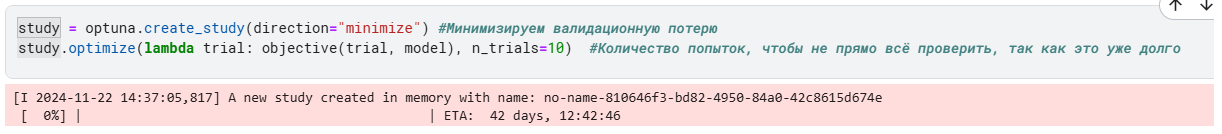

In [ ]:
! pip install optuna

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import optuna #Я хотела красиво через неё подбирать параметры, но CUDA сказала нет мне, пришлось вручную всё делать. Поэтому в конце кода есть ещё код для optuna, как было бы с ней хорошо...

Тут хочу сделать вот какое замечание:

В прошлой домашке у меня были проблемы с память. Я объяснила всё подробно, почему я использую ровно 10к текстов, почему каждый текст обрезаю до 1024 токена. Только при самых минимальных вещах у меня получилось обучить модель причём с просто отвратительным результатом. Прошлый раз я как-то не фиксировала и не помнила именно память gpu, сейчас же я это не забыла посмотреть (так как была не в таком шоке и подошла к этому делу с холодной головой). Вот следующие скрины: 1 - до загрузки модели, 2 - после загрузки моедели и попытки пройти с теми параметрами, которые были на паре + по TrainingArguments также получается. То есть даже не смотря на то, что я следую разбору домашки (не полностью компирую код, ведь тогда в этом просто нет сымсла), я не могу запустить обучение даже одного подбора, так как по памяти оно просто не проходит. Если я сто-то делаю не так, то прошу в комментарии к дз прямо конкретно разобрать, в каком месте что-то пошло не так. Иначе получается, что никто не пришёл к нужному результату задания (Это всё сводится к тому, что мы подбираем параметры, пока у нас не закончатся ресурсы. Мне очень грустно от эого, так как хочется больше потыкать в модель, но, увы, я ограничена ресурсами и всё сводится как раз к тому, чего не хотелось бы: просто заупскание кода раз за разом).


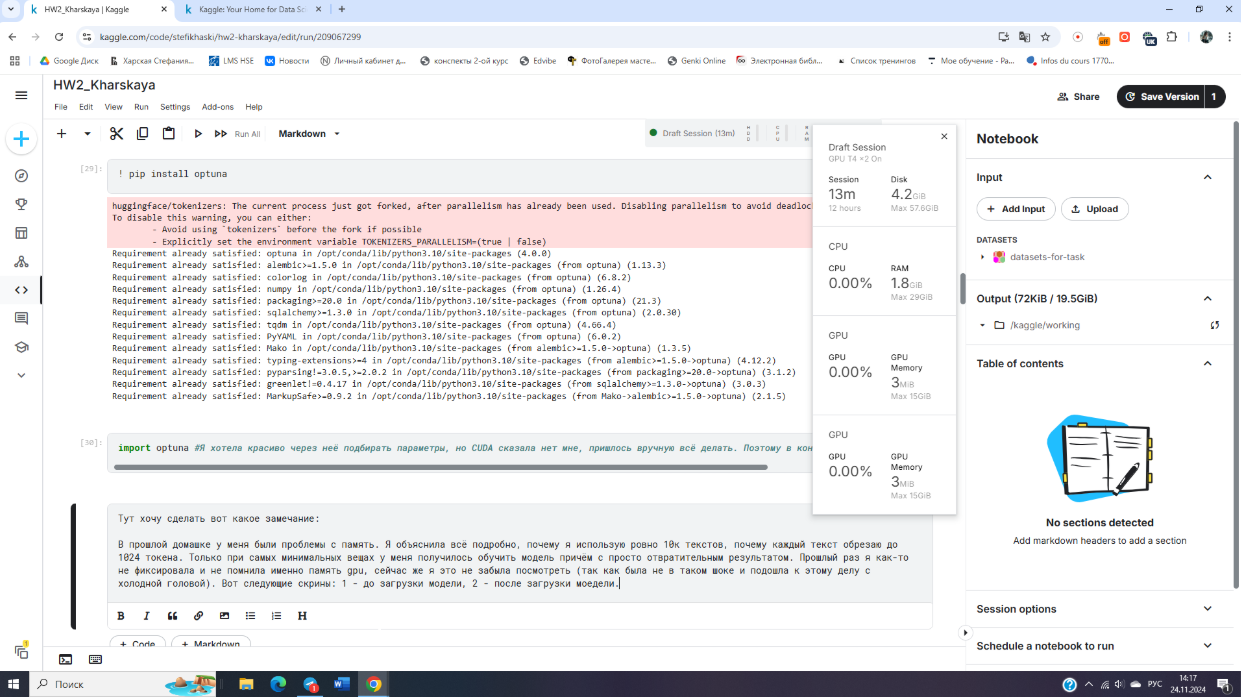

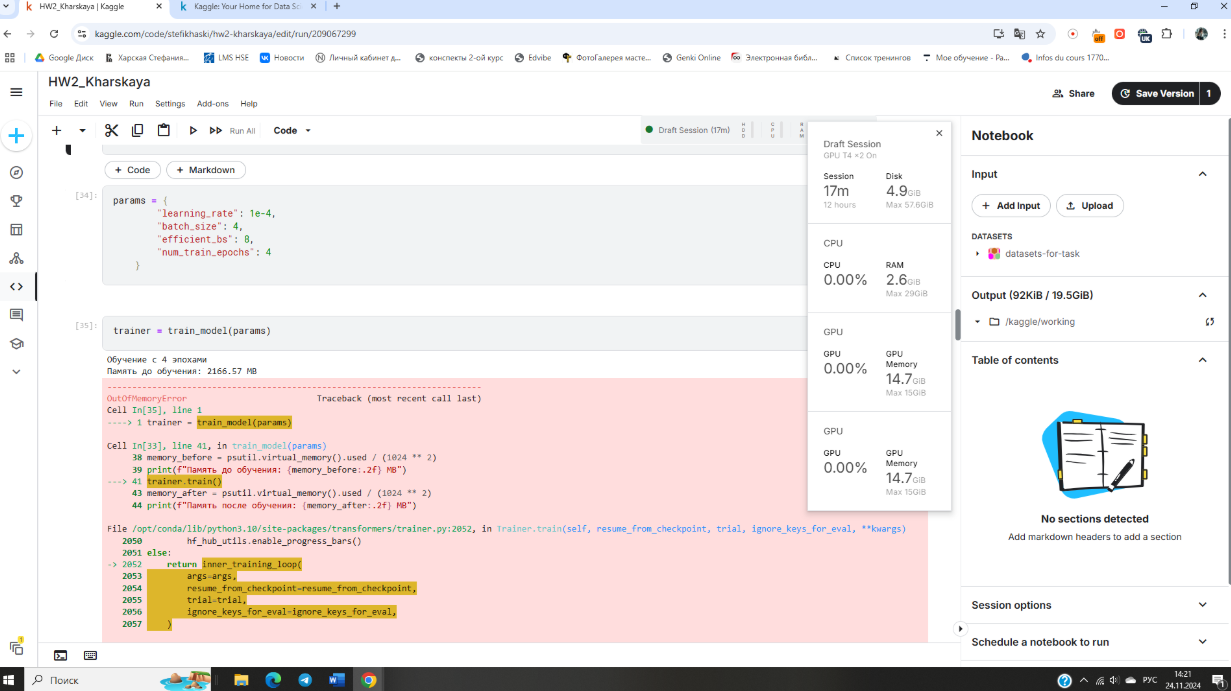

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained('google/long-t5-tglobal-base')

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def train_model(params):
    experiment_name = f"lr:{params['learning_rate']}_bs:{params['batch_size']}_acc:{params['efficient_bs']}_epochs:{params['num_train_epochs']}"
    output_dir = f"experiments/{experiment_name}"
    os.makedirs(output_dir, exist_ok=True)

    #Для обучения
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",  #Оцениваем в конце каждой эпохи
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=params['batch_size'],
        gradient_accumulation_steps=int(params['efficient_bs'] / params['batch_size']),
        num_train_epochs=params['num_train_epochs'],
        save_strategy="epoch",  #Сохраняем модель после каждой эпохи
        logging_dir=f"{output_dir}/logs",
        logging_first_step=True,
        logging_steps=100,
        logging_strategy="epoch",
        save_total_limit=params['num_train_epochs'],
        bf16=True,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="tensorboard"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_eval,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    print(f"Обучение с {params['num_train_epochs']} эпохами")

    memory_before = psutil.virtual_memory().used / (1024 ** 2)
    print(f"Память до обучения: {memory_before:.2f} MB")

    trainer.train()

    memory_after = psutil.virtual_memory().used / (1024 ** 2)
    print(f"Память после обучения: {memory_after:.2f} MB")

    trainer.save_model(output_dir)  #Сохраняемся вручную на всякий случай

    return trainer


In [ ]:
params = {
        "learning_rate": 1e-4,
        "batch_size": 4,
        "efficient_bs": 8,
        "num_train_epochs": 4
    }

In [ ]:
trainer = train_model(params)

Обучение с 4 эпохами
Память до обучения: 2166.57 MB


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 83, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/longt5/modeling_longt5.py", line 2017, in forward
    encoder_outputs = self.encoder(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/longt5/modeling_longt5.py", line 1517, in forward
    layer_outputs = layer_module(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/longt5/modeling_longt5.py", line 1197, in forward
    self_attention_outputs = self.layer[0](
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/longt5/modeling_longt5.py", line 1094, in forward
    attention_output = self.TransientGlobalSelfAttention(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/longt5/modeling_longt5.py", line 945, in forward
    key_states = torch.cat([key_states, side_key_states], dim=2)
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 78.12 MiB is free. Process 2328 has 14.66 GiB memory in use. Of the allocated memory 14.32 GiB is allocated by PyTorch, and 160.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Обнулим всё, чтобы было место для того, чтобы хоть что-то обучить. Код с разбора берёт слишком много памяти и надо уменьшать параметры подбора. Для этого я очищу память и возьму минимальные значения. Скрин после применения очистки.

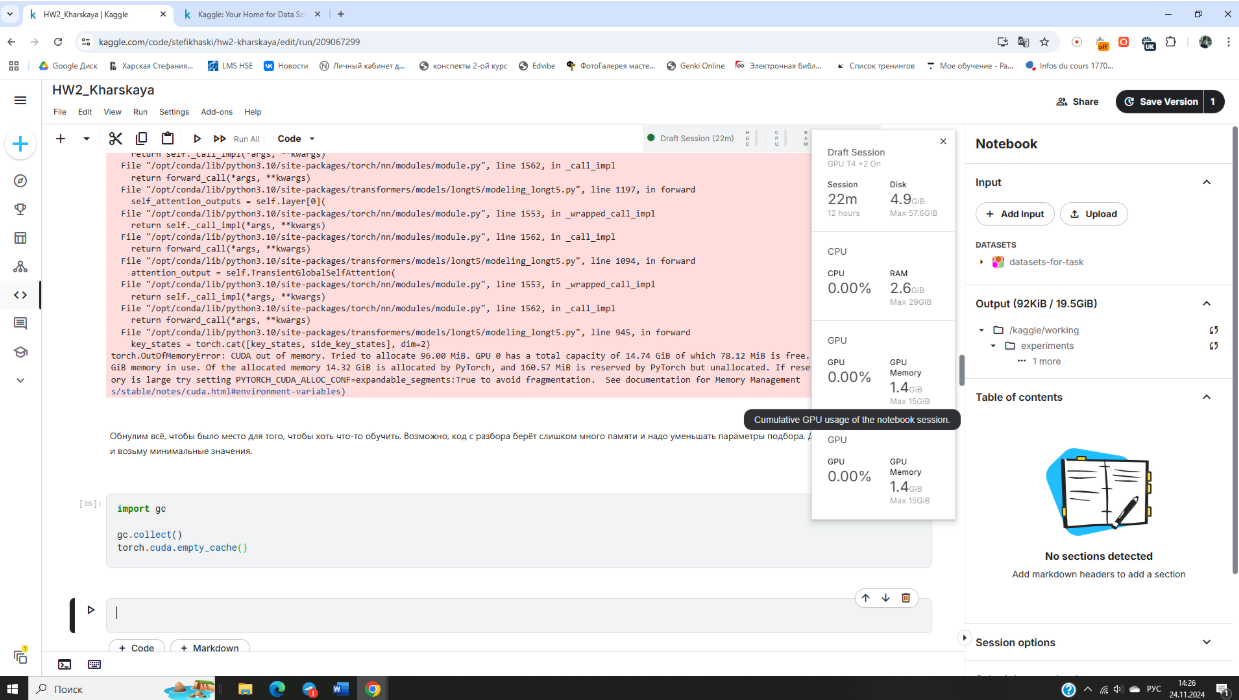

По времени должно быть:

Обучение с 1 эпохами
Память до обучения: 2867.37 MB
 [ 3/312 00:17 < 1:29:11, 0.06 it/s, Epoch 0.01/

Если получится обучить, о будет хоть небольшой результат. Буду тогда идти по стратегии: от меньшего к большему.

И это почти максимум по памяти, то есть большую часть параметров я даже поменять не смогу:

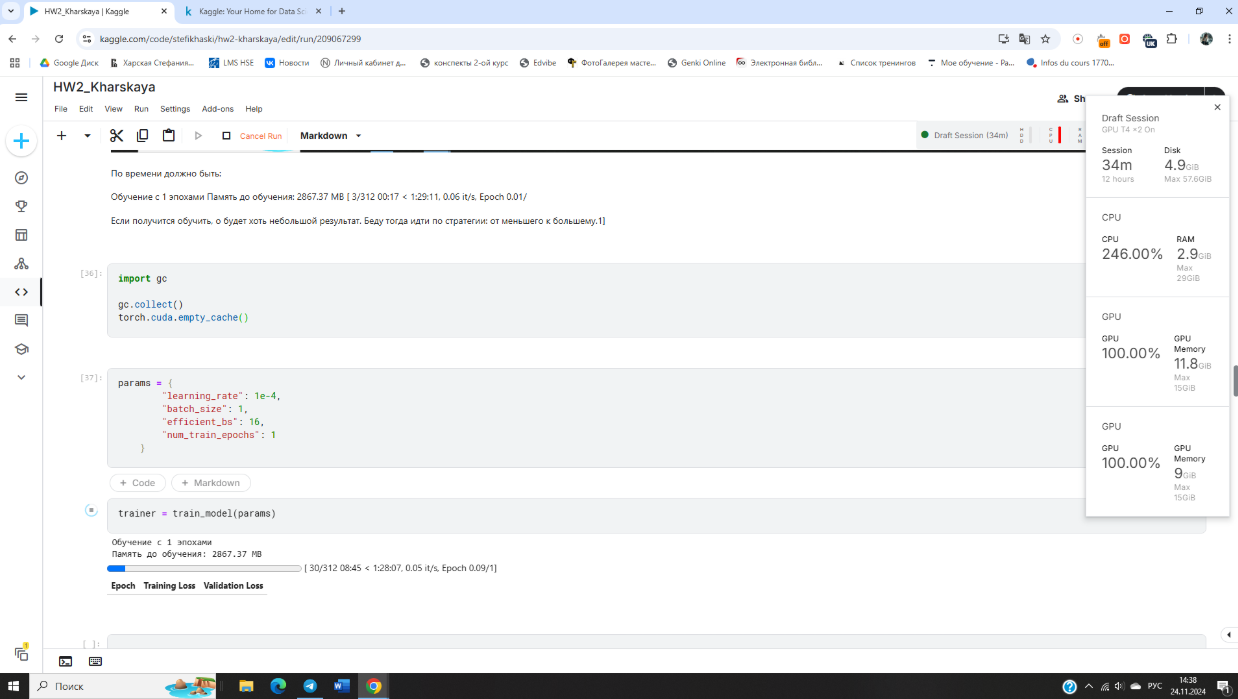

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
params = {
        "learning_rate": 1e-4,
        "batch_size": 1,
        "efficient_bs": 16,
        "num_train_epochs": 1
    }

In [ ]:
trainer = train_model(params)

Обучение с 1 эпохами
Память до обучения: 2867.37 MB


Epoch,Training Loss,Validation Loss
0,1.832100,0.318381


Память после обучения: 3158.35 MB


Обучилось как-то. Посмотрим, чо вообще тут за реузльтаты у нас...

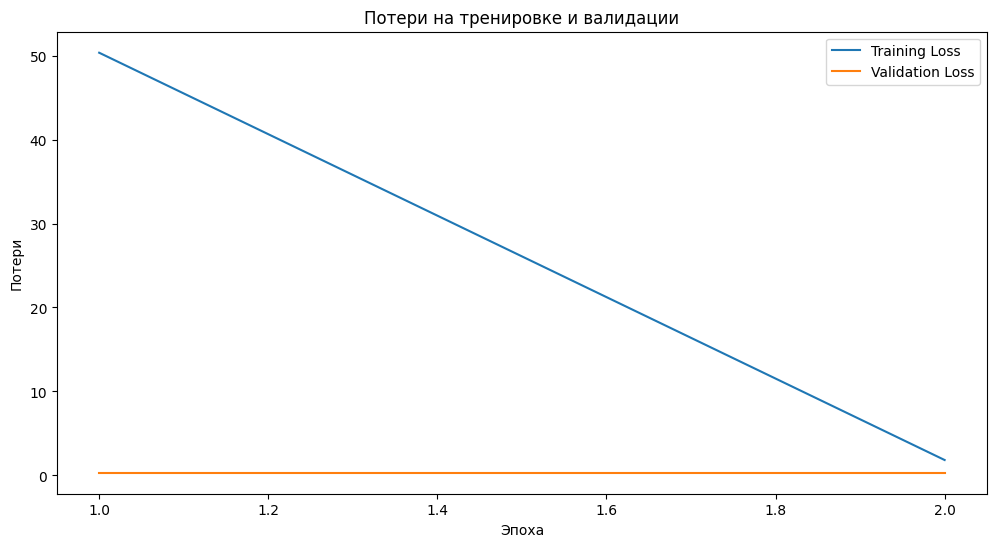

In [ ]:
history = trainer.state.log_history

train_loss_per_epoch = []
eval_loss_per_epoch = []

for log in history:
    if 'loss' in log and 'epoch' in log:
        train_loss_per_epoch.append(log['loss'])
    if 'eval_loss' in log and 'epoch' in log:
        eval_loss_per_epoch.append(log['eval_loss'])

if len(train_loss_per_epoch) < len(eval_loss_per_epoch):
    last_train_loss = train_loss_per_epoch[-1] if train_loss_per_epoch else 0
    train_loss_per_epoch.extend([last_train_loss] * (len(eval_loss_per_epoch) - len(train_loss_per_epoch)))
elif len(eval_loss_per_epoch) < len(train_loss_per_epoch):
    last_eval_loss = eval_loss_per_epoch[-1] if eval_loss_per_epoch else 0
    eval_loss_per_epoch.extend([last_eval_loss] * (len(train_loss_per_epoch) - len(eval_loss_per_epoch)))

epochs = range(1, len(eval_loss_per_epoch) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_per_epoch, label='Training Loss')
plt.plot(epochs, eval_loss_per_epoch, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на тренировке и валидации')
plt.legend()
plt.show()

In [ ]:
def generate_summaries_after_training(model, tokenizer, dataset, batch_size=8, max_length=512):
    summaries = []
    total_batches = len(dataset) // batch_size + (1 if len(dataset) % batch_size != 0 else 0)

    for i in tqdm(range(0, len(dataset), batch_size), desc='Идёт генерация', total=total_batches):
        batch = dataset[i:i + batch_size]['article']
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length)

        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        with torch.no_grad():
            summary_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=512,
                early_stopping=True
            )

        batch_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        summaries.extend(batch_summaries)
    return summaries

In [ ]:
trained_model = trainer.model
trained_tokenizer = trainer.tokenizer

In [ ]:
test_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, filtered_data['test'])
validation_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, filtered_data['validation'])

Идёт генерация: 100%|██████████| 561/561 [21:11<00:00,  2.27s/it]


In [ ]:
scores_test = rouge_score.compute(
    predictions=test_summaries, references=filtered_data['test']['highlights']
)
print(scores_test)

{'rouge1': 0.32298914023146463, 'rouge2': 0.12855230784340171, 'rougeL': 0.22830656585898185, 'rougeLsum': 0.22823997812489358}


In [ ]:
scores_valid = rouge_score.compute(
    predictions=validation_summaries, references=filtered_data['validation']['highlights']
)
print(scores_valid)

{'rouge1': 0.32590207393695625, 'rouge2': 0.1304561464621089, 'rougeL': 0.22884141582258963, 'rougeLsum': 0.2287138741280439}


Я не думала, что получится лучше, чем в прошлой домашке... Вот так было прошлый раз: {'rouge1': 0.17008810499131047, 'rouge2': 0.02427769180972239, 'rougeL': 0.12054400130898657, 'rougeLsum': 0.12063526325244575} Сейчас явно намного лучше!

По графику хорошо, что loss падает (это приближено к картинке стандартной), но всё равно плохо (Но лучше, чем было прошлый раз). Теперь надо очистить опять всё и попробовать что-то увеличить. Точно хочу посмотреть на эпохи, чтобы понять, что происходит с loss. Также уменьшила loss, должно быть качественнее обучение (на паре даже видели это на примерах). Однако ещё больше уменьшать будет странным решением, по времени, наверное, совсем улечу далеко. Попробовала увеличить батч до двух с efficient_bs=16 (сразу вылет по времени, с 32 и 64 аналогично). Поскольку при выполнении прошлой домашке Владимир писал некоторым, что можно ставить 1 батч (и тогда запустится), то я поступлю также.

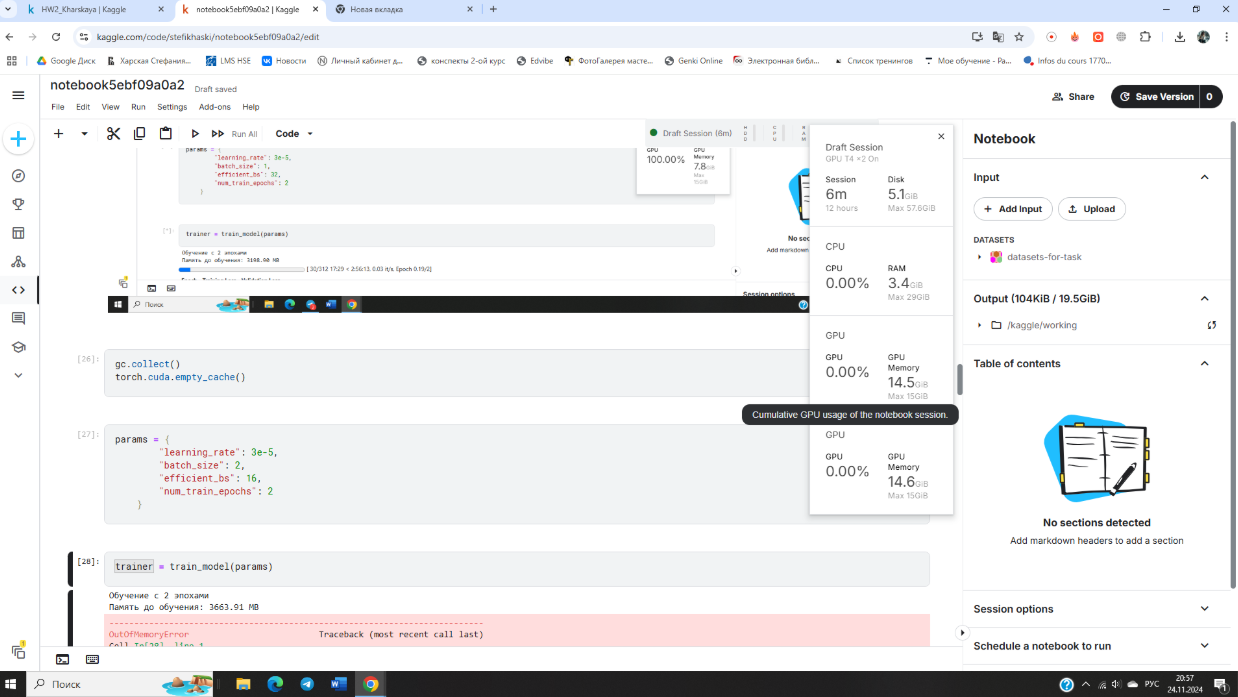

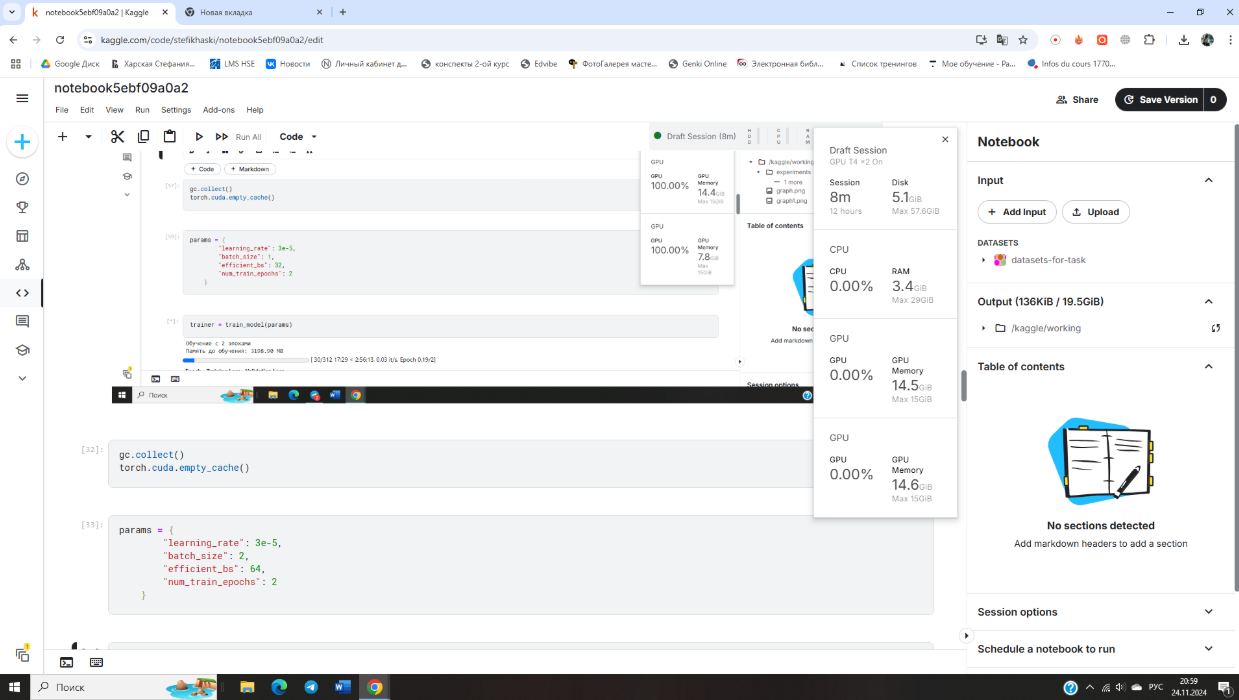

То есть по итогу запуска ясно, что максимум 2 эпохи (на трёх умирает память), размер батча 1, lr 3е-5 одно из стандартных маленьких значений (дальше время будет слишком долгим). Осталось понять, что делать с efiicient_bs. При 64 память не проходит. А вот при 32ух понадобится на всё про всё с предсказаниями около 4ёх часов... Ну, иного выхода нет. Остаётся надеятся, что результат обучения будет лучше, чем с 1 эпохой.

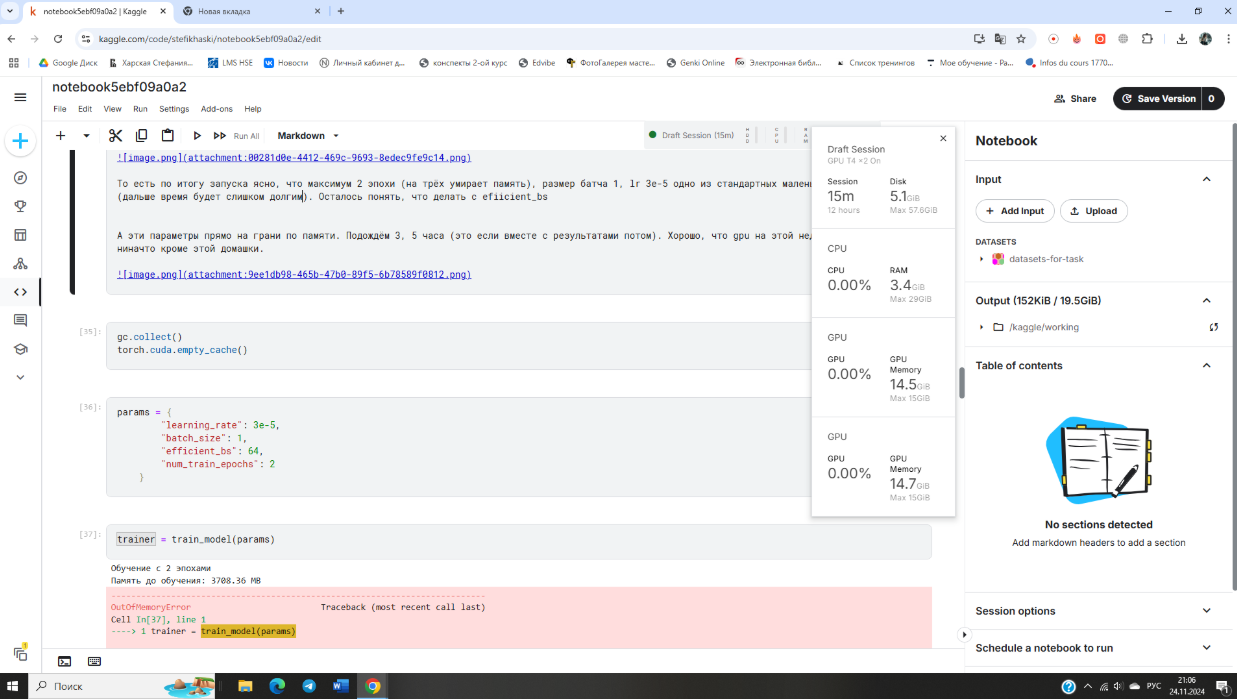

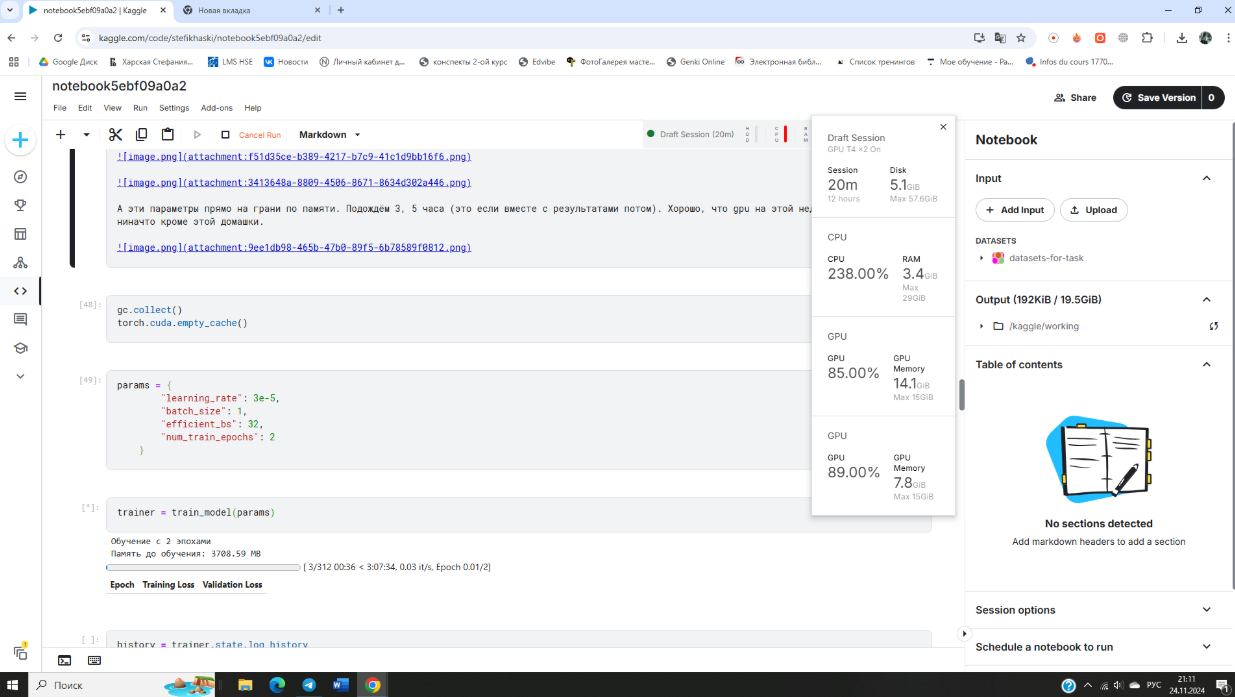


In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
params = {
        "learning_rate": 3e-5,
        "batch_size": 1,
        "efficient_bs": 32,
        "num_train_epochs": 2
    }

In [ ]:
trainer = train_model(params)

Обучение с 2 эпохами
Память до обучения: 3708.59 MB


Epoch,Training Loss,Validation Loss
0,6.483800,0.395853
1,0.411500,0.343253


Память после обучения: 3628.45 MB


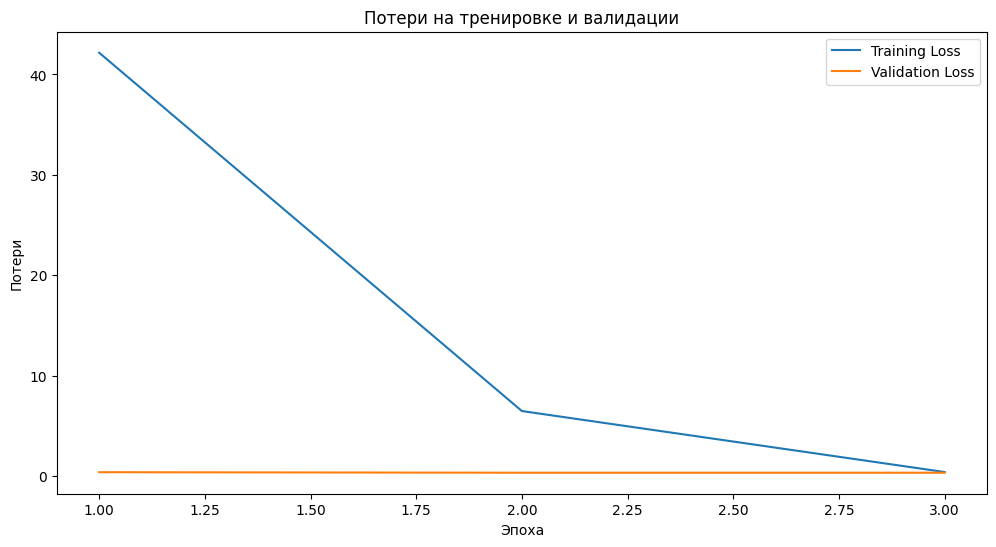

In [ ]:
history = trainer.state.log_history

train_loss_per_epoch = []
eval_loss_per_epoch = []

for log in history:
    if 'loss' in log and 'epoch' in log:
        train_loss_per_epoch.append(log['loss'])
    if 'eval_loss' in log and 'epoch' in log:
        eval_loss_per_epoch.append(log['eval_loss'])

if len(train_loss_per_epoch) < len(eval_loss_per_epoch):
    last_train_loss = train_loss_per_epoch[-1] if train_loss_per_epoch else 0
    train_loss_per_epoch.extend([last_train_loss] * (len(eval_loss_per_epoch) - len(train_loss_per_epoch)))
elif len(eval_loss_per_epoch) < len(train_loss_per_epoch):
    last_eval_loss = eval_loss_per_epoch[-1] if eval_loss_per_epoch else 0
    eval_loss_per_epoch.extend([last_eval_loss] * (len(train_loss_per_epoch) - len(eval_loss_per_epoch)))

epochs = range(1, len(eval_loss_per_epoch) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_per_epoch, label='Training Loss')
plt.plot(epochs, eval_loss_per_epoch, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на тренировке и валидации')
plt.legend()
plt.show()

In [ ]:
trained_model = trainer.model
trained_tokenizer = trainer.tokenizer

In [ ]:
test_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, filtered_data['test'])
validation_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, filtered_data['validation'])

Идёт генерация: 100%|██████████| 561/561 [20:11<00:00,  2.16s/it]


In [ ]:
scores_test = rouge_score.compute(
    predictions=test_summaries, references=filtered_data['test']['highlights']
)
print(scores_test)

{'rouge1': 0.2661866560624859, 'rouge2': 0.09959504936747196, 'rougeL': 0.1910301625270167, 'rougeLsum': 0.19103909816473444}


In [ ]:
scores_valid = rouge_score.compute(
    predictions=validation_summaries, references=filtered_data['validation']['highlights']
)
print(scores_valid)

{'rouge1': 0.2666185593596738, 'rouge2': 0.10105311694506894, 'rougeL': 0.1913155145130449, 'rougeLsum': 0.19128769579305316}


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
def compute_corpus_bleu(references, summaries):
    reference_lists = [[ref.split() for ref in ref_group] for ref_group in references]
    summary_lists = [summary.split() for summary in summaries]
    bleu_score = corpus_bleu(reference_lists, summary_lists)
    return bleu_score

In [ ]:
print(compute_corpus_bleu(filtered_data['validation']['highlights'], validation_summaries))

0.41815424405542534


In [ ]:
print(compute_corpus_bleu(filtered_data['test']['highlights'], test_summaries))

0.41408916577426624


Результаты оказались хуже, чем с минимальными параметрами (но график выглядит чуть лучше, падает туда, куда надо). Хотя это в любом случае лучше чем то, что было в прошлом дз. Это несколько расстраивает. Я хочу попробовать посмотреть, получится ли для 3х эпох. По памяти хорошо, но по времени это очень много и я не готова тратить столько ресурсов, учитывая, что для других домашних заданий параллельно gpu тоже нужен.

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
params = {
        "learning_rate": 1e-4,
        "batch_size": 1,
        "efficient_bs": 16,
        "num_train_epochs": 3
    }

In [ ]:
trainer = train_model(params)

Обучение с 3 эпохами
Память до обучения: 3714.43 MB


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Хотела ещё раз посмотреть на размер батча. Но нет, выше одного не могу поднять.

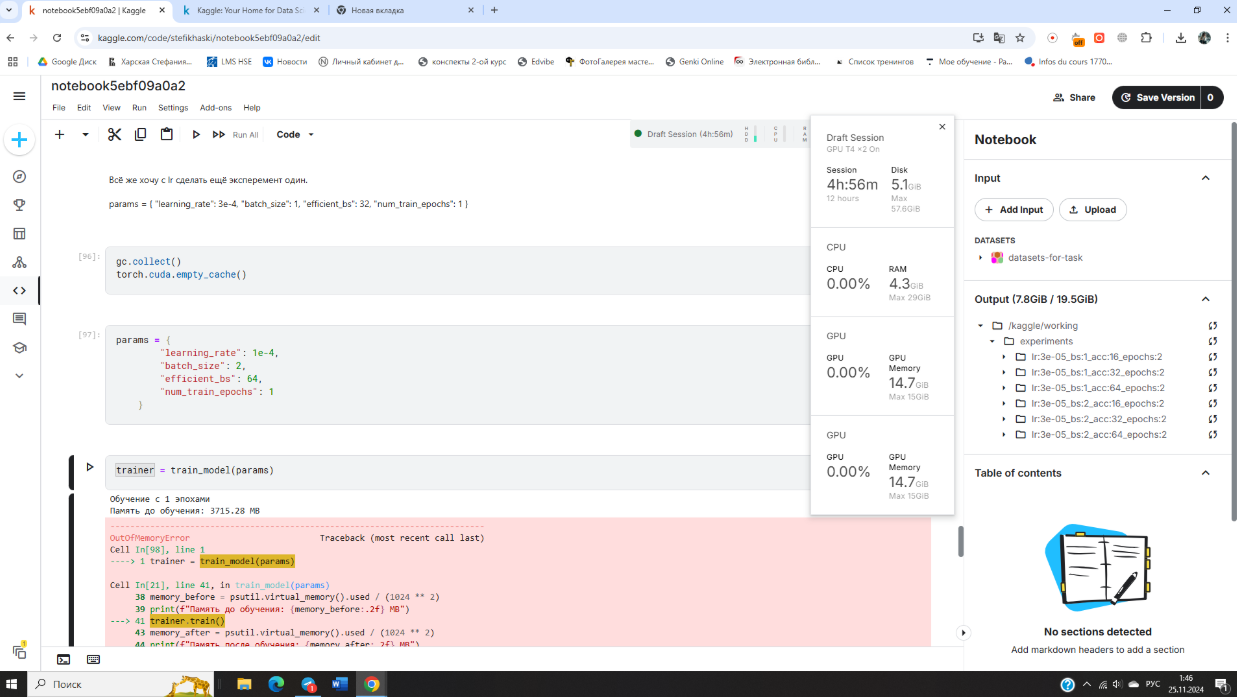

Финальный эксперимент хочу с lr сделать. Времени он много не займёт и это должно быть достаточным для задания, ведь задача в целом посмотреть на апараметры и подобрать оптимальные в моей ситуации.

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
params = {
        "learning_rate": 3e-4,
        "batch_size": 1,
        "efficient_bs": 32,
        "num_train_epochs": 1
    }

In [ ]:
trainer = train_model(params)

Обучение с 1 эпохами
Память до обучения: 2715.51 MB


Epoch,Training Loss,Validation Loss
0,1.500900,0.316401


Память после обучения: 3718.89 MB


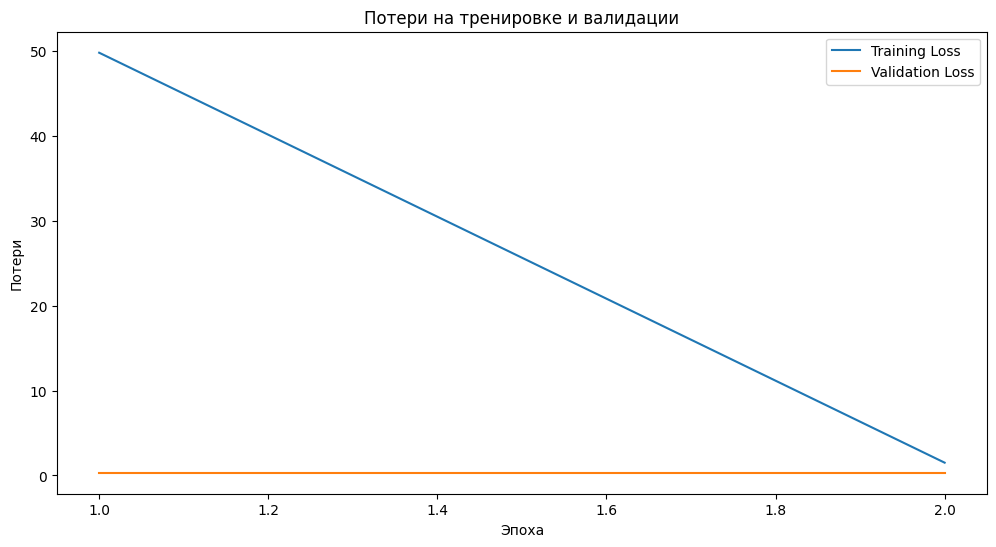

In [ ]:
history = trainer.state.log_history

train_loss_per_epoch = []
eval_loss_per_epoch = []

for log in history:
    if 'loss' in log and 'epoch' in log:
        train_loss_per_epoch.append(log['loss'])
    if 'eval_loss' in log and 'epoch' in log:
        eval_loss_per_epoch.append(log['eval_loss'])

if len(train_loss_per_epoch) < len(eval_loss_per_epoch):
    last_train_loss = train_loss_per_epoch[-1] if train_loss_per_epoch else 0
    train_loss_per_epoch.extend([last_train_loss] * (len(eval_loss_per_epoch) - len(train_loss_per_epoch)))
elif len(eval_loss_per_epoch) < len(train_loss_per_epoch):
    last_eval_loss = eval_loss_per_epoch[-1] if eval_loss_per_epoch else 0
    eval_loss_per_epoch.extend([last_eval_loss] * (len(train_loss_per_epoch) - len(eval_loss_per_epoch)))

epochs = range(1, len(eval_loss_per_epoch) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_per_epoch, label='Training Loss')
plt.plot(epochs, eval_loss_per_epoch, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на тренировке и валидации')
plt.legend()
plt.show()

Training loss чуть меньше упал (1.832100 vs 1.500900)

In [ ]:
trained_model = trainer.model
trained_tokenizer = trainer.tokenizer

In [ ]:
test_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, filtered_data['test'])
validation_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, filtered_data['validation'])

Идёт генерация: 100%|██████████| 561/561 [22:22<00:00,  2.39s/it]


In [ ]:
scores_test = rouge_score.compute(
    predictions=test_summaries, references=filtered_data['test']['highlights']
)
print(scores_test)

{'rouge1': 0.3242287644821512, 'rouge2': 0.1298147971809723, 'rougeL': 0.2297210098721149, 'rougeLsum': 0.22974068585436302}


In [ ]:
scores_valid = rouge_score.compute(
    predictions=validation_summaries, references=filtered_data['validation']['highlights']
)
print(scores_valid)

{'rouge1': 0.32407258668071887, 'rouge2': 0.12930060871812188, 'rougeL': 0.22869499117363667, 'rougeLsum': 0.2286965801694978}


In [ ]:
print(compute_corpus_bleu(filtered_data['validation']['highlights'], validation_summaries))

0.4305830054000435


In [ ]:
print(compute_corpus_bleu(filtered_data['test']['highlights'], test_summaries))

0.4333984000246228


По реузльтатам от первого эксперимента не очень отличается, где-то по тосночти выше, где-то по точности ниже. Мне кажется, разницы особой тут нет, оно всё примерно на одном уровне. Даже loss хоть и упал меньше, чем в первом эксперименте, всё равно значение, на мой взгляд, не настолько критичное. Поскольку разницы нет большой. Мне кажется, что отчасти вот этот вариант лучше, ведь lr меньше, а это значит, что в дальнейшем обучение будет чуть качественнее проходить. На разборе домашки было видно, что меньший lr даёт более качественные результаты с большими значениями других объектов, поэтому остановлюсь на этой финальной модели и параметрах.

 Делаем теперь инференс.

In [ ]:
import random

In [ ]:
def generate_summary(model, tokenizer, input_text):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=max_length)

    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)

    with torch.no_grad():
        summary_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask
            early_stopping=True
        )

    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_summary

In [ ]:
inference_results = []
for _ in tqdm(range(10)):
    random_idx = random.randint(0, len(filtered_data['test']) - 1)
    input_text = filtered_data['test'][random_idx]['article']
    reference_summary = filtered_data['test'][random_idx]['highlights']

    generated_summary = generate_summary(trained_model, trained_tokenizer, input_text)

    #Сохраняем результаты инференса
    inference_results.append({
        "text": input_text,
        "predicted_summary": generated_summary,
        "original_summary": reference_summary
    })

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


In [ ]:
inference_df = pd.DataFrame(inference_results)

In [ ]:
inference_df

,text,predicted_summary,original_summary
0,They call themselves the 'Thelma and Louise of...,Shannah Kennedy and Lyndall Mitchell are teach...,Shannah Kennedy and Lyndall Mitchell are 'Thel...
1,While the 3pm slump has most of us reaching fo...,Taline Gabrielian has recreated the entire ran...,"Taline Gabrielian, founder of Hippie Lane app ..."
2,On paper Chelsea’s team sheet looked like an i...,Jose Mourinho is staying true to the game . Ed...,Chelsea played out a 0-0 draw with Arsenal at ...
3,It was one of Barcelona's easier nights in the...,Neymar is a blend of Cristiano Ronaldo and Lio...,Barcelona cruised into UEFA Champions League s...
4,Atletico Madrid and Real Madrid couldn't be se...,NEW: Atletico Madrid goalkeeper Jan Oblak made...,Atletico Madrid and Real Madrid draw 0-0 at Vi...
5,Iain Duncan Smith has launched a scathing atta...,NEW: Work and Pensions Secretary says Ed Milib...,Work and Pensions Secretary hailed the Tories ...
6,Kolo Toure has warned Raheem Sterling that lea...,Raheem Sterling has been warned about the dang...,"Raheem Sterling has turned down a £100,000-a-w..."
7,The Indiana Pacers' Chris Copeland and his wif...,Chris Copeland and his wife were stabbed durin...,"Chris Copeland and his wife, Katrine Saltare, ..."
8,A couple bought a Beanie Baby for £10 at a car...,Leah Rogers and Ryan Flanaghan bought a rare p...,"Leah Rogers, 20, and Ryan Flanaghan, 22, bough..."
9,It was good while it lasted. Starbucks announc...,Starbucks says a computer outage that affected...,"Point-of-sale shutdown is effecting 8,000 Star..."


In [ ]:
inference_df.to_excel("./inference_results.xlsx", index=False)

In [ ]:
for i in range(10):
    print('Предсказано')
    print(inference_df['predicted_summary'][i])
    print('\\\\')
    print('Оригинал')
    print(inference_df['original_summary'][i])
    print('----------------')

Предсказано
Shannah Kennedy and Lyndall Mitchell are teaching their Masterclass Of Wellness to CEOs and executives across Australia . They teach skills and strategies which can be implemented into people's every day lives .
\\
Оригинал
Shannah Kennedy and Lyndall Mitchell are 'Thelma and Louise of wellness' The pair have decades of life coaching and retreat experience . Run a course called the Masterclass of Wellness: The Boardroom Retreat . Teach mindfulness to CEOs and executives across Australia . Clients include NAB, Macquarie Bank, Sportsgirl, PwC and kikki.K . Skills taught include dealing with stress, and accumulative mindfulness .
----------------
Предсказано
Taline Gabrielian has recreated the entire range of chocolate bar favourites, including Mars Bars, Snickers, Bounty, Twix and Cherry Ripe . Taline Gabrielian, 33, of Sydney's Northern Beaches has recreated the entire range of chocolate bar favourites, including Mars Bars, Snickers, Bounty, Twix and Cherry Ripe .
\\
Оригина


Видно, что предсказанные summary короче оригинальных. Это логично,ведь если смотреть на первое распределние, то видно, что тексты в основном не очень длинные и сейчас на рандомных текстах могли просто попасться те саммари, которые как раз отклоняются от средней длинный текстов в большую сторону.

по текстам:

1 - Основная информация была передана моделью. Нет только уточнения по названиям и каким-то деталям, но это всё равно отличное саммари.

2 - Уже хуже. Повторяющаяся информация (оба придложения об одном и том же). Нет важной информации о том, что это raw food, нет информаци о герое статьи.

3 - Тоже не очень получилось, так как нет информации про футбольный клуб, добавил ту информацию, которая в саммари не очень нужна и не очень подходит по смыслу.

4 - Последнюю часть про Неймара он сделал основной, хотя в статье упор был на матч отчасти.

5 - Неплохо суммировал матч, про который говорилось в статье, но немного странно построил предложение второе.

6 - Основная логическая проблема: в предсказанном тексте достижение лейбористов перепутано с достижением правых. В статье говорится о том, что это политика правых способстоввала увеличению рабочей силы. С другой стороны, в оригинальном саммари нет этой идеи. То есть в предсказанном тексте есть хорошая информация, если бы он не перепутал лейбристов и консерваторов.

7 - Вроде бы всё неплохо.

8 - Нет деталей и дважды повторяется одна и та же информация

9 - Можно было добавить чуть больше деталей, но и так неплохо

10 - Тоже хорошее саммари, но без деталей сильных.

Что могу сказать по итогу. Кажется по соотношению хорроших саммари к не очень на примере рандомных текстов полчается отразить метрику ROUGE. Большая часть саммари нужно улучшать, но есть часть прямо хорошая.ь В целом, мне нравится результат. Учитывая то, как ограничены ресурсы, получилось вполне сносную точность выбить. Если не обучать модель, то там вообще кошмар какие низкие метрики (первая домашка и первый пункт из неё). Плюс, сейчас результат явно лучше, благодаря ограничению верхнему на 2048 токеноа (а не просто срез на 1024 всего) и благодаря кое-каким аргументам в trainer.

In [ ]:
inference_df['original_summary'][0]

"Shannah Kennedy and Lyndall Mitchell are 'Thelma and Louise of wellness' The pair have decades of life coaching and retreat experience . Run a course called the Masterclass of Wellness: The Boardroom Retreat . Teach mindfulness to CEOs and executives across Australia . Clients include NAB, Macquarie Bank, Sportsgirl, PwC and kikki.K . Skills taught include dealing with stress, and accumulative mindfulness ."

Второй эксперимент через разбиение (подход “кроим - сшиваем”):


* разбейте строки из первой части ДЗ пополам (то есть на тексты длиной 512 токенов)
* обучите модель t5-small с подбором параметров
* сделав инференс, объедините саммари для ранее разбитых текстов в один текст (то есть два саммари в один)
* посчитайте те же метрики, что и в первой части, оцените суммаризацию квалитативно, напишите вывод

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
filtered_data

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 4485
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 3869
    })
})

Я решила пойти следующим методом: делим по полам и смотрим на конец предложения. Что касается саммари, то если оно у нас очень короткое (состоит из одного предложения, например), то тогда и к первой части статьи, и ко второй записывается полное саммари.

In [ ]:
def split_text(text):
    tokens = tokenizer.tokenize(text)
    total_tokens = len(tokens)
    mid_point = int(total_tokens / 2)

    sentences = nltk.sent_tokenize(text)

    part1, part2 = [], []
    token_count = 0

    for sentence in sentences:
        tokenized_sentence = tokenizer.tokenize(sentence)
        token_count += len(tokenized_sentence)
        if token_count <= mid_point:
            part1.append(sentence)
        else:
            part2.append(sentence)

    if not part2:
        part2 = part1.copy()
    elif not part1:
        part1 = part2.copy()

    return [" ".join(part1), " ".join(part2)]

Запукаем тут сплит, чтобы у нас не было странного формата. Всё будет в одном датасете.

In [ ]:
def preprocess(dataset_split, split_name):
    articles, summaries, ids = [], [], []
    for example in tqdm(dataset_split, desc=f"Processing {split_name}"):
        parts = split_text(example["article"])
        summary_parts = split_text(example["highlights"])

        articles.extend(parts)
        summaries.extend(summary_parts[:len(parts)])
        ids.extend([example.get("id", None)] * len(parts))  #Если нет ID, заполняем None

    #Проверка на совпадение длин, если что-то пойдёт не так
    if len(articles) != len(summaries):
        raise ValueError(f"Длины articles ({len(articles)}) и summaries ({len(summaries)}) не совпадают.")

    return Dataset.from_dict({
        "article": articles,
        "highlights": summaries,
        "id": ids
    })

In [ ]:
train_data = preprocess(filtered_data["train"], "train")
valid_data = preprocess(filtered_data["validation"], "validation")

Processing validation: 100%|██████████| 4485/4485 [01:28<00:00, 50.53it/s]


In [ ]:
train_data['article'][0] #Проверка на уменьшение статьи

'(CNN)  -- The National Football League has indefinitely suspended Atlanta Falcons quarterback Michael Vick without pay, officials with the league said Friday. NFL star Michael Vick is set to appear in court Monday. A judge will have the final say on a plea deal. Earlier, Vick admitted to participating in a dogfighting ring as part of a plea agreement with federal prosecutors in Virginia. "Your admitted conduct was not only illegal, but also cruel and reprehensible. Your team, the NFL, and NFL fans have all been hurt by your actions," NFL Commissioner Roger Goodell said in a letter to Vick. Goodell said he would review the status of the suspension after the legal proceedings are over. In papers filed Friday with a federal court in Virginia, Vick also admitted that he and two co-conspirators killed dogs that did not fight well. Falcons owner Arthur Blank said Vick\'s admissions describe actions that are "incomprehensible and unacceptable." The suspension makes "a strong statement that c

Токенизируем и начнём обучать

In [ ]:
def preprocess_function(examples):
    inputs = examples['article']
    targets = examples['highlights']
    model_inputs = tokenizer(inputs)
    labels = tokenizer(text_target=targets)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [ ]:
train_dataset = train_data.map(
    preprocess_function,
    batched=True,
    remove_columns=['article', 'highlights', 'id']
)
valid_dataset = valid_data.map(
    preprocess_function,
    batched=True,
    remove_columns=['article', 'highlights', 'id']
)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8970 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 20000
})

In [ ]:
valid_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 8970
})

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Суть кода никак не меняется, так как optuna тоже не прошла по памяти

In [ ]:
def train_model(params):
    experiment_name = f"lr:{params['learning_rate']}_bs:{params['batch_size']}_acc:{params['efficient_bs']}_epochs:{params['num_train_epochs']}"
    output_dir = f"experiments/{experiment_name}"
    os.makedirs(output_dir, exist_ok=True)

    #Для обучения
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",  #Оцениваем в конце каждой эпохи
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=params['batch_size'],
        gradient_accumulation_steps=int(params['efficient_bs'] / params['batch_size']),
        num_train_epochs=params['num_train_epochs'],
        save_strategy="epoch",  #Сохраняем модель после каждой эпохи
        logging_dir=f"{output_dir}/logs",
        logging_first_step=True,
        logging_steps=100,
        logging_strategy="epoch",
        save_total_limit=params['num_train_epochs'],
        bf16=True,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="tensorboard"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    print(f"Обучение с {params['num_train_epochs']} эпохами")

    memory_before = psutil.virtual_memory().used / (1024 ** 2)
    print(f"Память до обучения: {memory_before:.2f} MB")

    trainer.train()

    memory_after = psutil.virtual_memory().used / (1024 ** 2)
    print(f"Память после обучения: {memory_after:.2f} MB")

    trainer.save_model(output_dir)  #Сохраняемся вручную на всякий случай

    return trainer

У меня осталось 2 часа работы с GPU, поэтому экспериментов не очень много проведу. Поскольку модель маленькая и длины последовательностей не очень большие, то можно сразу попробовать что-то серьёзное по параметрам.




In [ ]:
params = {
        "learning_rate": 3e-4,
        "batch_size": 5,
        "efficient_bs": 8,
        "num_train_epochs": 4
    }

In [ ]:
trainer = train_model(params)

Обучение с 4 эпохами
Память до обучения: 2520.09 MB


Epoch,Training Loss,Validation Loss
1,2.681100,2.505391
2,2.495800,2.521534
3,2.384600,2.524185
4,2.306300,2.539300


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Память после обучения: 3343.86 MB


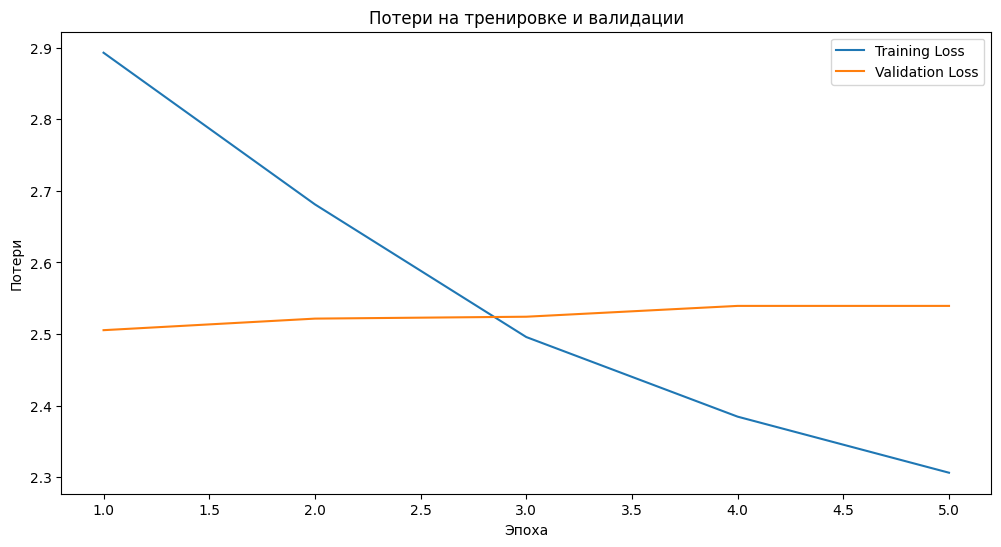

In [ ]:
history = trainer.state.log_history

train_loss_per_epoch = []
eval_loss_per_epoch = []

for log in history:
    if 'loss' in log and 'epoch' in log:
        train_loss_per_epoch.append(log['loss'])
    if 'eval_loss' in log and 'epoch' in log:
        eval_loss_per_epoch.append(log['eval_loss'])

if len(train_loss_per_epoch) < len(eval_loss_per_epoch):
    last_train_loss = train_loss_per_epoch[-1] if train_loss_per_epoch else 0
    train_loss_per_epoch.extend([last_train_loss] * (len(eval_loss_per_epoch) - len(train_loss_per_epoch)))
elif len(eval_loss_per_epoch) < len(train_loss_per_epoch):
    last_eval_loss = eval_loss_per_epoch[-1] if eval_loss_per_epoch else 0
    eval_loss_per_epoch.extend([last_eval_loss] * (len(train_loss_per_epoch) - len(eval_loss_per_epoch)))

epochs = range(1, len(eval_loss_per_epoch) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_per_epoch, label='Training Loss')
plt.plot(epochs, eval_loss_per_epoch, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на тренировке и валидации')
plt.legend()
plt.show()

In [ ]:
from collections import defaultdict

In [ ]:
def generate_summaries_after_training(model, tokenizer, dataset, batch_size=8):
    #Хранение промежуточных саммари по ид
    id_to_summaries = defaultdict(list)
    summaries = []
    total_batches = len(dataset["article"]) // batch_size + (1 if len(dataset["article"]) % batch_size != 0 else 0)

    for i in tqdm(range(0, len(dataset["article"]), batch_size), desc="Идёт генерация", total=total_batches):
        #Получаем батч статей
        batch_articles = dataset["article"][i:i + batch_size]
        batch_ids = dataset["id"][i:i + batch_size]

        #Токенизация
        inputs = tokenizer(batch_articles, return_tensors="pt")
        input_ids = inputs["input_ids"].to(model.device)
        attention_mask = inputs["attention_mask"].to(model.device)

        #Генерация
        with torch.no_grad():
            summary_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                early_stopping=True
            )

        batch_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

        #Саммари по ид
        for doc_id, summary in zip(batch_ids, batch_summaries):
            id_to_summaries[doc_id].append(summary)

    #Объединяем
    for doc_id, parts in id_to_summaries.items():
        summaries.append(" ".join(parts))

    return summaries

In [ ]:
test_data = preprocess(filtered_data["test"], "test")

Processing test: 100%|██████████| 3869/3869 [02:44<00:00, 23.51it/s]


In [ ]:
trained_model = trainer.model
trained_tokenizer = trainer.tokenizer

In [ ]:
test_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, test_data)
validation_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, valid_data)

Идёт генерация: 100%|██████████| 1122/1122 [05:25<00:00,  3.45it/s]


In [ ]:
scores_test = rouge_score.compute(
    predictions=test_summaries, references=filtered_data['test']['highlights']
)
print(scores_test)

{'rouge1': 0.2646512622966277, 'rouge2': 0.09360958359974861, 'rougeL': 0.19688141655485586, 'rougeLsum': 0.1968774740631093}


In [ ]:
scores_validation = rouge_score.compute(
    predictions=validation_summaries, references=filtered_data['validation']['highlights']
)
print(scores_validation)

{'rouge1': 0.26107306360265015, 'rouge2': 0.09003286680501768, 'rougeL': 0.19174651373170173, 'rougeLsum': 0.19174628530655416}


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
def compute_corpus_bleu(references, summaries):
    reference_lists = [[ref.split() for ref in ref_group] for ref_group in references]
    summary_lists = [summary.split() for summary in summaries]
    bleu_score = corpus_bleu(reference_lists, summary_lists)
    return bleu_score

In [ ]:
print(compute_corpus_bleu(filtered_data['test']['highlights'], test_summaries))

0.3932514465335975


In [ ]:
print(compute_corpus_bleu(filtered_data['validation']['highlights'], validation_summaries))

0.3922042461435275


Мда, получилось не очень. По лосу странно, да, и по метрикам так себе. Возможно, проблема в подходе, так как обубание текста в первой домашке у меня уже показывало не очень результаты.

Может, не стоило придцмывать велосипед, а взять просто параметры с семинара?

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
params = {
        "learning_rate": 1e-4,
        "batch_size": 4,
        "efficient_bs": 8,
        "num_train_epochs": 4
    }

In [ ]:
trainer = train_model(params)

Обучение с 4 эпохами
Память до обучения: 3333.72 MB


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,2.664600,2.464907
2,2.546000,2.465713
3,2.483100,2.471448
4,2.445400,2.476231


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Память после обучения: 3788.35 MB


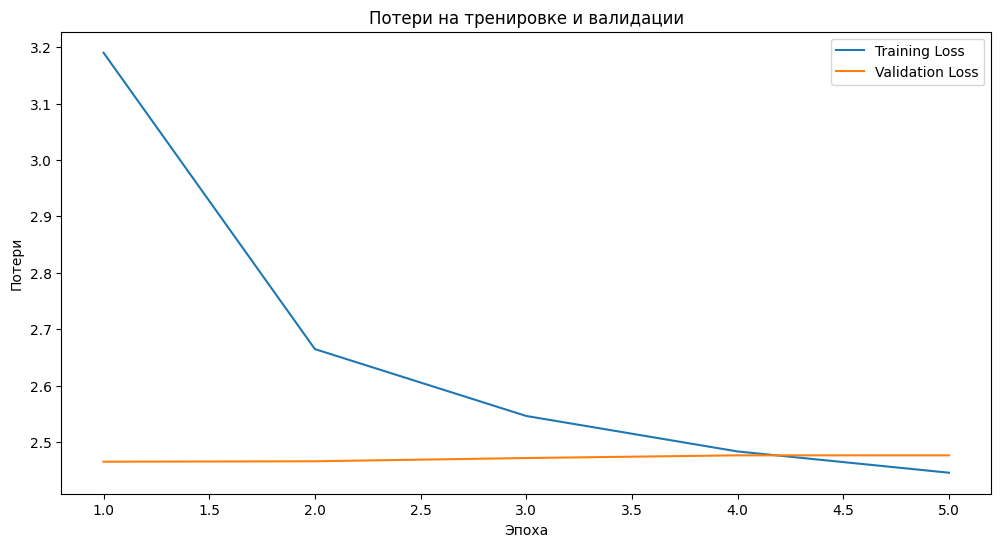

In [ ]:
history = trainer.state.log_history

train_loss_per_epoch = []
eval_loss_per_epoch = []

for log in history:
    if 'loss' in log and 'epoch' in log:
        train_loss_per_epoch.append(log['loss'])
    if 'eval_loss' in log and 'epoch' in log:
        eval_loss_per_epoch.append(log['eval_loss'])

if len(train_loss_per_epoch) < len(eval_loss_per_epoch):
    last_train_loss = train_loss_per_epoch[-1] if train_loss_per_epoch else 0
    train_loss_per_epoch.extend([last_train_loss] * (len(eval_loss_per_epoch) - len(train_loss_per_epoch)))
elif len(eval_loss_per_epoch) < len(train_loss_per_epoch):
    last_eval_loss = eval_loss_per_epoch[-1] if eval_loss_per_epoch else 0
    eval_loss_per_epoch.extend([last_eval_loss] * (len(train_loss_per_epoch) - len(eval_loss_per_epoch)))

epochs = range(1, len(eval_loss_per_epoch) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_per_epoch, label='Training Loss')
plt.plot(epochs, eval_loss_per_epoch, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на тренировке и валидации')
plt.legend()
plt.show()

In [ ]:
trained_model = trainer.model
trained_tokenizer = trainer.tokenizer

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


In [ ]:
test_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, test_data)
validation_summaries = generate_summaries_after_training(trained_model, trained_tokenizer, valid_data)

Идёт генерация: 100%|██████████| 1122/1122 [05:27<00:00,  3.43it/s]


In [ ]:
scores_test = rouge_score.compute(
    predictions=test_summaries, references=filtered_data['test']['highlights']
)
print(scores_test)

{'rouge1': 0.26745590834380994, 'rouge2': 0.09205074356371674, 'rougeL': 0.19627092463170853, 'rougeLsum': 0.19627914136462218}


In [ ]:
scores_validation = rouge_score.compute(
    predictions=validation_summaries, references=filtered_data['validation']['highlights']
)
print(scores_validation)

{'rouge1': 0.26367515539638664, 'rouge2': 0.08850513533724483, 'rougeL': 0.19232337499290422, 'rougeLsum': 0.19222472984949987}


In [ ]:
print(compute_corpus_bleu(filtered_data['test']['highlights'], test_summaries))

0.3896138409189913


In [ ]:
print(compute_corpus_bleu(filtered_data['validation']['highlights'], validation_summaries))

0.38887001111292


Вот! Уже лучше картинка по лосу и метрики хоть и не очень сильно отличаются, но чуть выше! Так как GPU закончились, то я сделаю инференс и завершу на этом домашку.

Возьмём также 10 текстов рандомных.

In [ ]:
import random

In [ ]:
shuffled_test = filtered_data['test'].shuffle(seed=42)
random_texts = shuffled_test.select(range(10))

In [ ]:
def preprocess_2(dataset_split):
    articles, summaries, ids = [], [], []
    for example in dataset_split:
        parts = split_text(example["article"])
        summary_parts = split_text(example["highlights"])

        articles.extend(parts)
        summaries.extend(summary_parts[:len(parts)])
        ids.extend([example.get("id", None)] * len(parts))  #Используем id или noone

    if len(articles) != len(summaries):
        raise ValueError(f"Lengths of articles ({len(articles)}) and summaries ({len(summaries)}) do not match.")

    return {
        "articles": articles,
        "summaries": summaries,
        "ids": ids
    }

In [ ]:
def generate_single_summary(model, tokenizer, input_text):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)

    with torch.no_grad():
        summary_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            early_stopping=True
        )

    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_summary

In [ ]:
def generate_summaries_for_parts(model, tokenizer, parts):
    summaries = []
    for part in parts:
        summary = generate_single_summary(model, tokenizer, part)
        summaries.append(summary)
    return summaries

In [ ]:
results = []
for example in tqdm(random_texts):
    article = example["article"]
    highlights = example["highlights"]
    article_id = example["id"]

    #Разбиваем текущую статью на части
    preprocessed = preprocess_2([example])  # Передаем только текущий example
    parts = preprocessed["articles"]
    part_summaries = generate_summaries_for_parts(model, tokenizer, parts) #Генерируем саммари для частей

    full_summary = " ".join(part_summaries) #Склеиваем саммари для полного текста

    results.append({
        "original_text": article,
        "original_summary": highlights,
        "predicted_summary": full_summary
    })

100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


In [ ]:
inference_df = pd.DataFrame(results)

In [ ]:
inference_df

,original_text,original_summary,predicted_summary
0,"He's part of one of the most famous, most watc...","Rob Kardashian, 28, has taken disappeared from...",Rob Kardashian is thought to have struggled wi...
1,(CNN)A 110-day cat-and-mouse chase spanning fr...,Sea Shepherd rescues the crew of an alleged po...,Cat-and-mouse chase spanning from Antarctic wa...
2,Thousands of children who fail maths and Engli...,David Cameron to announce that children will h...,David Cameron announces all children who do no...
3,A teenage boy who shot and killed a teacher an...,"Boy, 13, arrested after deadly attack at secon...",The 13-year-old boy is said to have listed 25 ...
4,"Keith Cameron, pictured, was jailed for five ...","Keith Cameron, 54, jailed for five years after...","Keith Cameron, 54, jailed for five years for s..."
5,(CNN)He might have just won one of sport's mos...,Jordan Spieth hails autistic younger sibling a...,Jordan Spieth wins Masters Masters at Augusta....
6,Middlesbrough manager Aitor Karanka declared t...,Norwich midfielder Alexander Tettey scored an ...,Middlesbrough beat Norwich 1-0 to move them to...
7,Three hours after giving birth to her longed-f...,Lianne Hindle suffered a cardiac arrest at Nor...,"Lianne Hindle, 37, died in the same hospital b..."
8,A dangerous 'death ring' has been spotted arou...,Death ring is made up of I-80 and Route 101 wh...,Scientists say the lethal ring is leaving tens...
9,A controversial US pastor has defended trying ...,In March Atlanta-based Reverend Creflo Dollar ...,Reverend Creflo Dollar launched an appeal last...


In [ ]:
for i in range(10):
    print('Предсказано')
    print(inference_df['predicted_summary'][i])
    print('\\\\')
    print('Оригинал')
    print(inference_df['original_summary'][i])
    print('----------------')

Предсказано
Rob Kardashian is a brother to Kim, Kourtney and Khloe. Rob shocked Instagram followers when he posted a picture of his sister Kim. His elder sister Khloe has previously revealed that she believes that Rob suffers from social anxiety.
\\
Оригинал
Rob Kardashian, 28, has taken disappeared from the media spotlight . His sister Khloe says he has 'social anxiety' Family discuss him in new episode of Keeping Up With The Kardashians .
----------------
Предсказано
Cat-and-mouse chase spanning from Antarctic waters to coast of west Africa unlikely end. The Thunder was found with nets in the water, illegally catching Patagonian toothfish. The Thunder was illegally caught Patagonian toothfish.
\\
Оригинал
Sea Shepherd rescues the crew of an alleged poaching ship it had chased for 110 days . The conservationist group had pursued the vessel since it was found illegally fishing off Antarctica, it says . Sea Shepherd captain tells CNN he believes the ship was deliberately sunk to destroy

Инференс на t5-long мне больше понравился) Тут намного больше ошибок. Есть странные предложения, что-то вообще не в тему, часть перепутана. Нет, конечно здорово, что это уже что-то осмысленное, но это далеко от идеала, что было понятно по графику и метрикам. 5ый текст, вроде бы, неплохой. Может, 8ой ещё по сути мысли в нужную сторону. Но остально очень плохо. Фразы странно построены, слова не очень подобраны. Тут даже удивительно, что разница в точности между t5-long не сказать, что очень большая. А вот по предсказанным cv как будто бы прямо очень колосальная.

Мне кажется, что подобный метод не очень классный. Возможно, если бы у меня было больше gpu, то я бы подбирала больше параметров и результаты получились лучше. Однако сам вопрос метода у меня вызывает вопросы. Я вот пошла путём того, что саммари мы не всегда делим, но насколько жто правильно? Не будет ли такого, что модель будет в небольшом залуждении, что два фрагмента текста и при этом одно саммари по сути. Плюс, граница разделения может идти по важной информации я старалась делить по предложениям, чтобы так были части осмысленнее, но ведь граница может проходить по фразе. То есть два предложение тесно связаны, а мы их разрубаем на два текста и скармливаем модели. Хвучит не очень. Опять же проблема с короткими саммари тоже стоит. Выглядит очень странно данный метод, хоть и по нагрузке оно легче получается.

Вот так в идеальном мире хотела подбирать параметры

In [ ]:
def train_model(params, tokenized_datasets, model, tokenizer, device):
    experiment_name = f"lr:{params['learning_rate']}_bs:{params['batch_size']}_acc:{params['efficient_bs']}_epochs:{params['num_train_epochs']}"
    output_dir = f"experiments/{experiment_name}"
    os.makedirs(output_dir, exist_ok=True)

    #Для обучения
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",  #Оцениваем в конце каждой эпохи
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['batch_size'],
        per_device_eval_batch_size=params['batch_size'],
        gradient_accumulation_steps=int(params['efficient_bs'] / params['batch_size']),
        num_train_epochs=params['num_train_epochs'],
        save_strategy="epoch",  #Сохраняем модель после каждой эпохи
        logging_dir=f"{output_dir}/logs",
        logging_first_step=True,
        logging_strategy="epoch",
        save_total_limit=2,
        bf16=True,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="tensorboard",
        disable_tqdm=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        tokenizer=tokenizer,
        data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    )

    print(f"Обучение с {params['num_train_epochs']} эпохами")

    memory_before = psutil.virtual_memory().used / (1024 ** 2)
    print(f"Память до обучения: {memory_before:.2f} MB")

    trainer.train()

    memory_after = psutil.virtual_memory().used / (1024 ** 2)
    print(f"Память после обучения: {memory_after:.2f} MB")

    #Запускаем
    train_result = trainer.train()
    trainer.save_model(output_dir)  #Сохраняемся вручную на всякий случай

    #Сохраняем результаты
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()

    #Валидации
    eval_metrics = trainer.evaluate()
    trainer.log_metrics("eval", eval_metrics)
    trainer.save_metrics("eval", eval_metrics)

    return eval_metrics["eval_loss"]

In [ ]:
def objective(trial, tokenized_datasets, model, device, tokenizer):

    learning_rate = trial.suggest_categorical("learning_rate", [1e-4])
    batch_size = trial.suggest_categorical("batch_size", [1])
    efficient_bs = trial.suggest_categorical("efficient_bs", [4])
    num_train_epochs = trial.suggest_categorical("num_train_epochs", [1])

    params = {
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "efficient_bs": efficient_bs,
        "num_train_epochs": num_train_epochs
    }

    val_loss = train_model(params, tokenized_datasets, model, tokenizer, device)

    return val_loss

In [ ]:
study = optuna.create_study(direction="minimize")  #Минимизируем валидационную потерю
study.optimize(lambda trial: objective(trial, tokenized_datasets, model, device, tokenizer), n_trials=1)  #Количество попыток в подборе гиперпараметров, чтобы не прямо всё проверить, так как это уже долго

In [ ]:
print(f"Лучшие праметры: {study.best_params}")